<span id="shors-algorithm" />

# Algoritmo de Shor

*Estimativa de uso: Três segundos em um processador Eagle r3 (OBSERVAÇÃO: esta é apenas uma estimativa. Seu tempo de execução pode variar)*

[O algoritmo de Shor,](https://epubs.siam.org/doi/abs/10.1137/S0036144598347011) desenvolvido por Peter Shor em 1994, é um algoritmo quântico inovador para fatorar números inteiros em tempo polinomial. Sua importância está na capacidade de fatorar números inteiros grandes exponencialmente mais rápido do que qualquer algoritmo clássico conhecido, ameaçando a segurança de sistemas criptográficos amplamente usados, como o RSA, que dependem da dificuldade de fatorar números grandes. Ao resolver esse problema de forma eficiente em um computador quântico suficientemente potente, o algoritmo de Shor poderia revolucionar campos como criptografia, segurança cibernética e matemática computacional, ressaltando o poder transformador da computação quântica.

Este tutorial se concentra na demonstração do algoritmo de Shor, fatorando 15 em um computador quântico.

Primeiro, definimos o problema de determinação de ordem e construímos os circuitos correspondentes a partir do protocolo de estimativa de fase quântica. Em seguida, executamos os circuitos de localização de ordens em hardware real usando circuitos de profundidade mais curta que podemos transpilar. A última seção completa o algoritmo de Shor conectando o problema de determinação de ordem à fatoração de números inteiros.

Encerramos o tutorial com uma discussão sobre outras demonstrações do algoritmo de Shor em hardware real, com foco nas implementações genéricas e naquelas adaptadas para fatorar números inteiros específicos, como 15 e 21.



Observação: este tutorial se concentra mais na implementação e na demonstração dos circuitos relativos ao algoritmo de Shor. Para obter um recurso educacional aprofundado sobre o material, consulte o curso [Fundamentals of quantum algorithms (Fundamentos de algoritmos qu](/learning/courses/fundamentals-of-quantum-algorithms/phase-estimation-and-factoring/introduction) ânticos) do Dr. John Watrous e os artigos na seção [Referências](#references).



<span id="requirements" />

### Requisitos

Antes de iniciar este tutorial, verifique se você tem os seguintes itens instalados:

*   Qiskit SDK v2.0 ou posterior com suporte à visualização (`pip install 'qiskit[visualization]'`)
*   Qiskit Runtime v0.40 ou posterior (`pip install qiskit-ibm-runtime`)



<span id="setup" />

### Configuração



In [3]:
import numpy as np
import pandas as pd
from fractions import Fraction
from math import floor, gcd, log

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import QFT, UnitaryGate
from qiskit.transpiler import CouplingMap, generate_preset_pass_manager
from qiskit.visualization import plot_histogram

from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2 as Sampler

<span id="step-1-map-classical-inputs-to-a-quantum-problem" />

## Etapa 1: mapear entradas clássicas para um problema quântico



<span id="background" />

### Histórico

O algoritmo de Shor para a fatoração de números inteiros utiliza um problema intermediário conhecido como problema *de determinação de ordem*. Nesta seção, demonstramos como resolver o problema de determinação de ordem usando *a estimativa de fase quântica*.



<span id="phase-estimation-problem" />

### Problema de estimativa de fase

No problema de estimativa de fase, recebemos um estado quântico $\ket{\psi}$ de $n$ qubits, juntamente com um circuito quântico unitário que atua em $n$ qubits. Prometemos que $\ket{\psi}$ é um vetor próprio da matriz unitária $U$ que descreve a ação do circuito, e nosso objetivo é calcular ou aproximar o valor próprio $\lambda = e^{2 \pi i \theta}$ ao qual $\ket{\psi}$ corresponde. Em outras palavras, o circuito deve produzir uma aproximação para o número $\theta \in [0, 1)$ satisfazendo $U \ket{\psi}= e^{2 \pi i \theta} \ket{\psi}.$ O objetivo do circuito de estimativa de fase é aproximar $\theta$ em $m$ bits. Em termos matemáticos, gostaríamos de encontrar $y$ de modo que $\theta \approx y / 2^m$, onde $y \in {0, 1, 2, \dots, 2^{m-1}}$. A imagem a seguir mostra o circuito quântico que estima $y$ em $m$ bits fazendo uma medição em $m$ qubits.



![Circuito de estimativa de fase quântica](/learning/images/courses/fundamentals-of-quantum-algorithms/phase-estimation-and-factoring/phase-estimation-procedure.svg)



No circuito acima, os qubits superiores $m$ são iniciados no estado $\ket{0^m}$ e os qubits inferiores $n$ são iniciados em $\ket{\psi}$, que promete ser um vetor próprio de $U$. O primeiro ingrediente do circuito de estimativa de fase são as operações unitárias controladas, responsáveis por realizar um *retorno de fase* para o qubit de controle correspondente. Essas unidades controladas são exponenciadas de acordo com a posição do qubit de controle, variando do bit menos significativo ao bit mais significativo. Como $\ket{\psi}$ é um vetor próprio de $U$, o estado dos qubits inferiores de $n$ não é afetado por essa operação, mas as informações de fase do valor próprio se propagam para os qubits superiores de $m$.



Acontece que, após a operação de retrocesso de fase por meio de unitários controlados, todos os estados possíveis dos $m$ qubits superiores são ortonormais entre si para cada vetor próprio $\ket{\psi}$ do unitário $U$. Portanto, esses estados são perfeitamente distinguíveis, e podemos girar a base que eles formam de volta para a base computacional para fazer uma medição. Uma análise matemática mostra que essa matriz de rotação corresponde à transformada quântica inversa de Fourier (QFT) no espaço de Hilbert $2^m$ -dimensional. A intuição por trás disso é que a estrutura periódica dos operadores de exponenciação modular está codificada no estado quântico, e o QFT converte essa periodicidade em picos mensuráveis no domínio da frequência.

Para uma compreensão mais aprofundada do motivo pelo qual o circuito QFT é empregado no algoritmo de Shor, recomendamos que o leitor consulte o curso [Fundamentos de algoritmos quânticos](/learning/courses/fundamentals-of-quantum-algorithms/phase-estimation-and-factoring/introduction).



Agora estamos prontos para usar o circuito de estimativa de fase para encontrar a ordem.



<span id="order-finding-problem" />

### Problema de localização de pedidos

Para definir o problema de determinação de ordem, começamos com alguns conceitos da teoria dos números. Primeiro, para qualquer número inteiro positivo $N$, defina o conjunto $\mathbb{Z}_N$ como $\mathbb{Z}_N = \{0, 1, 2, \dots, N-1\}.$ Todas as operações aritméticas em $\mathbb{Z}_N$ são realizadas no módulo $N$. Em particular, todos os elementos $a \in \mathbb{Z}_n$ que são coprimos de $N$ são especiais e constituem $\mathbb{Z}^*_N$ como $\mathbb{Z}^*_N = \{ a \in \mathbb{Z}_N : \mathrm{gcd}(a, N)=1 \}.$ Para um elemento $a \in \mathbb{Z}^*_N$, o menor número inteiro positivo $r$ tal que $a^r \equiv 1 \; (\mathrm{mod} \; N)$ é definido como a *ordem* de $a$ módulo $N$. Como veremos mais adiante, encontrar a ordem de um $a \in \mathbb{Z}^*_N$ nos permitirá fatorar $N$.



Para construir o circuito de determinação de ordem a partir do circuito de estimativa de fase, precisamos de duas considerações. Primeiro, precisamos definir o unitário $U$ que nos permitirá encontrar a ordem $r$ e, segundo, precisamos definir um vetor próprio $\ket{\psi}$ de $U$ para preparar o estado inicial do circuito de estimativa de fase.

Para conectar o problema de determinação de ordem à estimativa de fase, consideramos a operação definida em um sistema cujos estados clássicos correspondem a $\mathbb{Z}_N$, em que multiplicamos por um elemento fixo $a \in \mathbb{Z}^*_N$. Em particular, definimos esse operador de multiplicação $M_a$ de modo que $M_a \ket{x} = \ket{ax \; (\mathrm{mod} \; N)}$ para cada $x \in \mathbb{Z}_N$. Observe que está implícito que estamos tomando o produto módulo $N$ dentro do ket no lado direito da equação. Uma análise matemática mostra que $M_a$ é um operador unitário. Além disso, verifica-se que $M_a$ tem pares de vetores e valores próprios que nos permitem conectar a ordem $r$ de $a$ ao problema de estimativa de fase. Especificamente, para qualquer opção de $j \in \{0, \dots, r-1\}$, temos que $\ket{\psi_j} = \frac{1}{\sqrt{r}} \sum^{r-1}_{k=0} \omega^{-jk}_{r} \ket{a^k}$ é um vetor próprio de $M_a$ cujo valor próprio correspondente é $\omega^{j}_{r}$, onde $\omega^{j}_{r} = e^{2 \pi i \frac{j}{r}}.$



Por observação, vemos que um par de autovetor/valor próprio conveniente é o estado $\ket{\psi_1}$ com $\omega^{1}_{r} = e^{2 \pi i \frac{1}{r}}$. Portanto, se pudéssemos encontrar o vetor próprio $\ket{\psi_1}$, poderíamos estimar a fase $\theta=1/r$ com nosso circuito quântico e, portanto, obter uma estimativa da ordem $r$. Entretanto, não é fácil fazer isso, e precisamos considerar uma alternativa.

Vamos considerar o resultado do circuito se prepararmos o estado computacional $\ket{1}$ como o estado inicial. Esse não é um estado próprio de $M_a$, mas é a superposição uniforme dos estados próprios que acabamos de descrever acima. Em outras palavras, a relação a seguir é válida. $\ket{1} = \frac{1}{\sqrt{r}} \sum^{r-1}_{k=0} \ket{\psi_k}$ A implicação da equação acima é que, se definirmos o estado inicial como $\ket{1}$, obteremos exatamente o mesmo resultado de medição como se tivéssemos escolhido $k \in \{ 0, \dots, r-1\}$ uniformemente de forma aleatória e usado $\ket{\psi_k}$ como um vetor próprio no circuito de estimativa de fase. Em outras palavras, uma medição dos $m$ qubits superiores produz uma aproximação $y / 2^m$ do valor $k / r$ em que $k \in \{ 0, \dots, r-1\}$ é escolhido uniformemente de forma aleatória. Isso nos permite aprender $r$ com um alto grau de confiança após várias execuções independentes, que era o nosso objetivo.



<span id="modular-exponentiation-operators" />

### Operadores de exponenciação modular

Até agora, vinculamos o problema de estimativa de fase ao problema de determinação de ordem definindo $U = M_a$ e $\ket{\psi} = \ket{1}$ em nosso circuito quântico. Portanto, o último ingrediente restante é encontrar uma maneira eficiente de definir exponenciais modulares de $M_a$ como $M_a^k$ para $k = 1, 2, 4, \dots, 2^{m-1}$. Para realizar esse cálculo, descobrimos que, para qualquer potência $k$ que escolhermos, podemos criar um circuito para $M_a^k$ não iterando $k$ vezes o circuito para $M_a$, mas, em vez disso, calculando $b = a^k \; \mathrm{mod} \; N$ e, em seguida, usando o circuito para $M_b$. Como precisamos apenas das potências que são potências de 2, podemos fazer isso de forma classicamente eficiente usando o quadrado iterativo.



<span id="step-2-optimize-problem-for-quantum-hardware-execution" />

## Etapa 2: otimizar o problema para a execução do hardware quântico



<span id="specific-example-with-$n-=-15$-and-$a=2$" />

### Exemplo específico com $N = 15$ e $a=2$

Podemos fazer uma pausa aqui para discutir um exemplo específico e construir o circuito de determinação de ordem para $N=15$. Observe que os possíveis $a \in \mathbb{Z}_N^*$ não triviais para $N=15$ são $a \in \{2, 4, 7, 8, 11, 13, 14 \}$. Para este exemplo, escolhemos $a=2$. Construiremos o operador $M_2$ e os operadores de exponenciação modular $M_2^k$.



A ação de $M_2$ nos estados da base computacional é a seguinte. $M_2 \ket{0} = \ket{0} \quad M_2 \ket{5} = \ket{10} \quad M_2 \ket{10} = \ket{5}$ $M_2 \ket{1} = \ket{2} \quad M_2 \ket{6} = \ket{12} \quad M_2 \ket{11} = \ket{7}$ $M_2 \ket{2} = \ket{4} \quad M_2 \ket{7} = \ket{14} \quad M_2 \ket{12} = \ket{9}$ $M_2 \ket{3} = \ket{6} \quad M_2 \ket{8} = \ket{1} \quad M_2 \ket{13} = \ket{11}$ $M_2 \ket{4} = \ket{8} \quad M_2 \ket{9} = \ket{3} \quad M_2 \ket{14} = \ket{13}$ Por observação, podemos ver que os estados da base são embaralhados, portanto, temos uma matriz de permutação. Podemos construir essa operação em quatro qubits com portas de troca. A seguir, construímos as operações $M_2$ e $M_2$ controladas.



In [4]:
def M2mod15():
    """
    M2 (mod 15)
    """
    b = 2
    U = QuantumCircuit(4)

    U.swap(2, 3)
    U.swap(1, 2)
    U.swap(0, 1)

    U = U.to_gate()
    U.name = f"M_{b}"

    return U

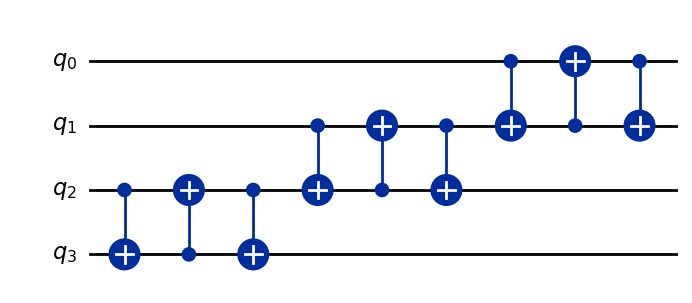

In [7]:
# Get the M2 operator
M2 = M2mod15()

# Add it to a circuit and plot
circ = QuantumCircuit(4)
circ.compose(M2, inplace=True)
circ.decompose(reps=2).draw(output="mpl", fold=-1)

In [8]:
def controlled_M2mod15():
    """
    Controlled M2 (mod 15)
    """
    b = 2
    U = QuantumCircuit(4)

    U.swap(2, 3)
    U.swap(1, 2)
    U.swap(0, 1)

    U = U.to_gate()
    U.name = f"M_{b}"
    c_U = U.control()

    return c_U

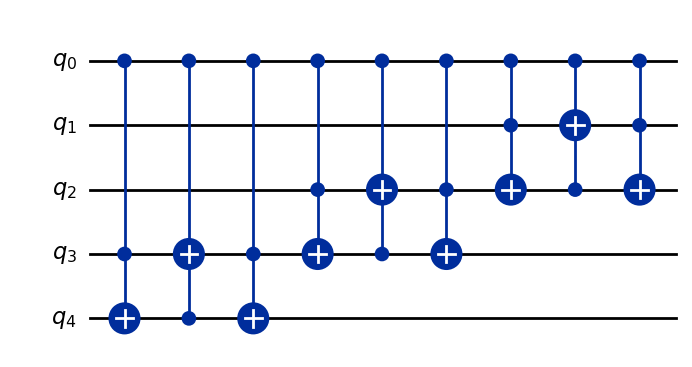

In [9]:
# Get the controlled-M2 operator
controlled_M2 = controlled_M2mod15()

# Add it to a circuit and plot
circ = QuantumCircuit(5)
circ.compose(controlled_M2, inplace=True)
circ.decompose(reps=1).draw(output="mpl", fold=-1)

As portas que atuam em mais de dois qubits serão decompostas em portas de dois qubits.



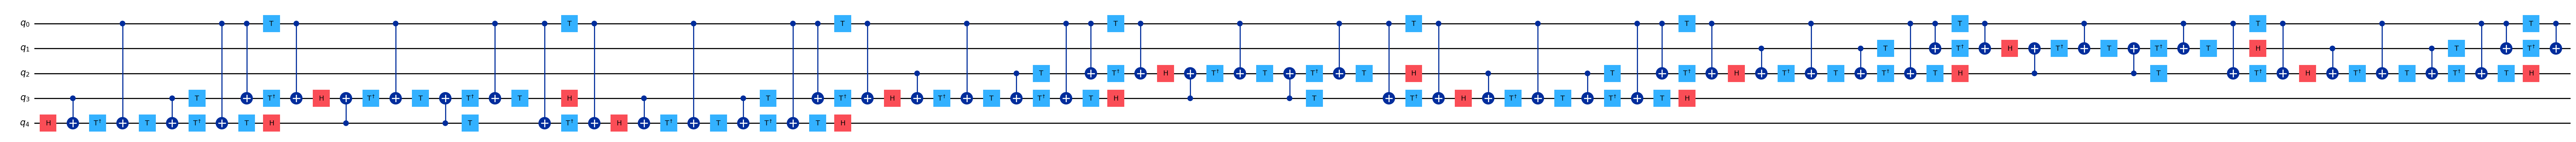

In [10]:
circ.decompose(reps=2).draw(output="mpl", fold=-1)

Agora precisamos construir os operadores de exponenciação modular. Para obter precisão suficiente na estimativa de fase, usaremos oito qubits para a medição da estimativa. Portanto, precisamos construir $M_b$ com $b = a^{2^k} \; (\mathrm{mod} \; N)$ para cada $k = 0, 1, \dots, 7$.



In [11]:
def a2kmodN(a, k, N):
    """Compute a^{2^k} (mod N) by repeated squaring"""
    for _ in range(k):
        a = int(np.mod(a**2, N))
    return a

In [12]:
k_list = range(8)
b_list = [a2kmodN(2, k, 15) for k in k_list]

print(b_list)

[2, 4, 1, 1, 1, 1, 1, 1]


Como podemos ver na lista de valores de $b$, além de $M_2$ que construímos anteriormente, também precisamos construir $M_4$ e $M_1$. Observe que o $M_1$ atua trivialmente nos estados da base computacional, portanto, é simplesmente o operador de identidade.

$M_4$ atua sobre os estados da base computacional da seguinte forma. $M_4 \ket{0} = \ket{0} \quad M_4 \ket{5} = \ket{5} \quad M_4 \ket{10} = \ket{10}$ $M_4 \ket{1} = \ket{4} \quad M_4 \ket{6} = \ket{9} \quad M_4 \ket{11} = \ket{14}$ $M_4 \ket{2} = \ket{8} \quad M_4 \ket{7} = \ket{13} \quad M_4 \ket{12} = \ket{3}$ $M_4 \ket{3} = \ket{12} \quad M_4 \ket{8} = \ket{2} \quad M_4 \ket{13} = \ket{7}$ $M_4 \ket{4} = \ket{1} \quad M_4 \ket{9} = \ket{6} \quad M_4 \ket{14} = \ket{11}$

Portanto, essa permutação pode ser construída com a seguinte operação de troca.



In [13]:
def M4mod15():
    """
    M4 (mod 15)
    """
    b = 4
    U = QuantumCircuit(4)

    U.swap(1, 3)
    U.swap(0, 2)

    U = U.to_gate()
    U.name = f"M_{b}"

    return U

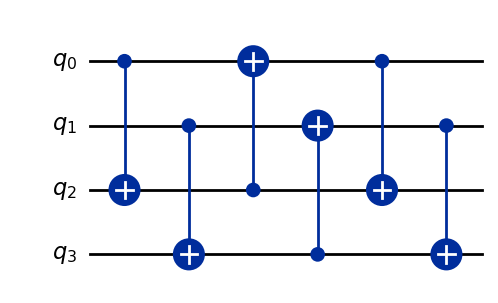

In [14]:
# Get the M4 operator
M4 = M4mod15()

# Add it to a circuit and plot
circ = QuantumCircuit(4)
circ.compose(M4, inplace=True)
circ.decompose(reps=2).draw(output="mpl", fold=-1)

In [15]:
def controlled_M4mod15():
    """
    Controlled M4 (mod 15)
    """
    b = 4
    U = QuantumCircuit(4)

    U.swap(1, 3)
    U.swap(0, 2)

    U = U.to_gate()
    U.name = f"M_{b}"
    c_U = U.control()

    return c_U

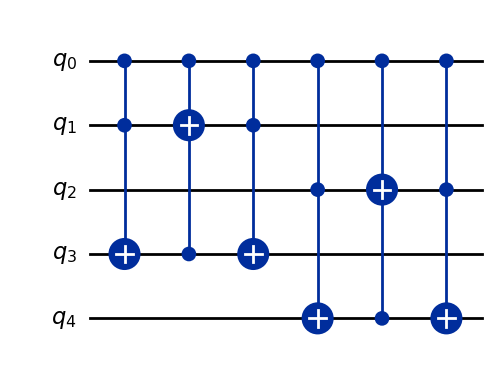

In [16]:
# Get the controlled-M4 operator
controlled_M4 = controlled_M4mod15()

# Add it to a circuit and plot
circ = QuantumCircuit(5)
circ.compose(controlled_M4, inplace=True)
circ.decompose(reps=1).draw(output="mpl", fold=-1)

As portas que atuam em mais de dois qubits serão decompostas em portas de dois qubits.



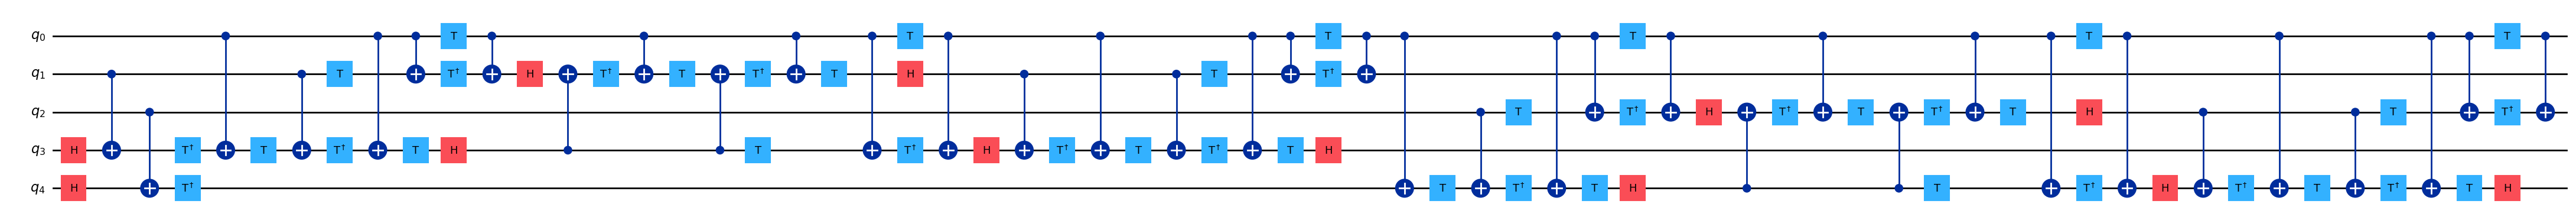

In [17]:
circ.decompose(reps=2).draw(output="mpl", fold=-1)

Vimos que os operadores $M_b$ para um determinado $b \in \mathbb{Z}^*_N$ são operações de permutação. Devido ao tamanho relativamente pequeno do problema de permutação que temos aqui, já que o $N=15$ requer apenas quatro qubits, conseguimos sintetizar essas operações diretamente com as portas do `SWAP` por inspeção. Em geral, essa pode não ser uma abordagem dimensionável. Em vez disso, talvez seja necessário construir a matriz de permutação explicitamente e usar a classe `UnitaryGate` e os métodos de transpilação do Qiskit para sintetizar essa matriz de permutação. No entanto, isso pode resultar em circuitos significativamente mais profundos. A seguir é fornecido um exemplo.



In [18]:
def mod_mult_gate(b, N):
    """
    Modular multiplication gate from permutation matrix.
    """
    if gcd(b, N) > 1:
        print(f"Error: gcd({b},{N}) > 1")
    else:
        n = floor(log(N - 1, 2)) + 1
        U = np.full((2**n, 2**n), 0)
        for x in range(N):
            U[b * x % N][x] = 1
        for x in range(N, 2**n):
            U[x][x] = 1
        G = UnitaryGate(U)
        G.name = f"M_{b}"
        return G

qubits: 4
2q-depth: 114
2q-size: 120
Operator counts: OrderedDict({'cx': 58, 'swap': 46, 'u': 43, 'u2': 7, 'circuit-224': 1, 'circuit-227': 1, 'circuit-230': 1, 'circuit-233': 1, 'circuit-236': 1, 'circuit-239': 1, 'circuit-242': 1, 'circuit-245': 1, 'circuit-248': 1, 'circuit-251': 1, 'circuit-254': 1, 'circuit-257': 1, 'circuit-260': 1, 'circuit-263': 1, 'circuit-266': 1, 'circuit-269': 1})


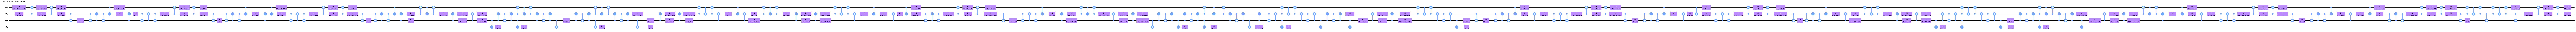

In [19]:
# Let's build M2 using the permutation matrix definition
M2_other = mod_mult_gate(2, 15)

# Add it to a circuit
circ = QuantumCircuit(4)
circ.compose(M2_other, inplace=True)
circ = circ.decompose()

# Transpile the circuit and get the depth
coupling_map = CouplingMap.from_line(4)
pm = generate_preset_pass_manager(coupling_map=coupling_map)
transpiled_circ = pm.run(circ)

print(f"qubits: {circ.num_qubits}")
print(
    f"2q-depth: {transpiled_circ.depth(lambda x: x.operation.num_qubits==2)}"
)
print(f"2q-size: {transpiled_circ.size(lambda x: x.operation.num_qubits==2)}")
print(f"Operator counts: {transpiled_circ.count_ops()}")
transpiled_circ.decompose().draw(
    output="mpl", fold=-1, style="clifford", idle_wires=False
)

Vamos comparar essas contagens com a profundidade do circuito compilado de nossa implementação manual da porta $M_2$.



qubits: 4
2q-depth: 9
2q-size: 9
Operator counts: OrderedDict({'cx': 9})


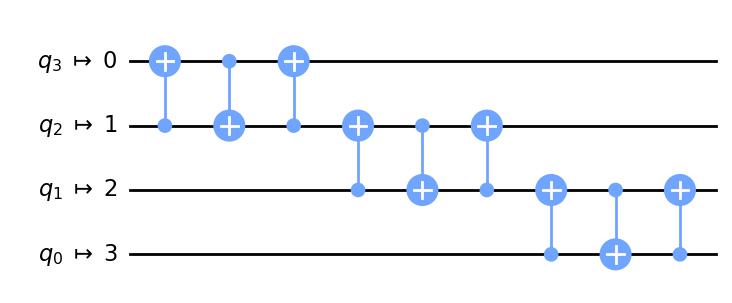

In [20]:
# Get the M2 operator from our manual construction
M2 = M2mod15()

# Add it to a circuit
circ = QuantumCircuit(4)
circ.compose(M2, inplace=True)
circ = circ.decompose(reps=3)

# Transpile the circuit and get the depth
coupling_map = CouplingMap.from_line(4)
pm = generate_preset_pass_manager(coupling_map=coupling_map)
transpiled_circ = pm.run(circ)

print(f"qubits: {circ.num_qubits}")
print(
    f"2q-depth: {transpiled_circ.depth(lambda x: x.operation.num_qubits==2)}"
)
print(f"2q-size: {transpiled_circ.size(lambda x: x.operation.num_qubits==2)}")
print(f"Operator counts: {transpiled_circ.count_ops()}")
transpiled_circ.draw(
    output="mpl", fold=-1, style="clifford", idle_wires=False
)

Como podemos ver, a abordagem da matriz de permutação resultou em um circuito significativamente profundo, mesmo para uma única porta $M_2$, em comparação com nossa implementação manual. Portanto, continuaremos com nossa implementação anterior das operações do $M_b$.



Agora, estamos prontos para construir o circuito de determinação de ordem completa usando nossos operadores de exponenciação modular controlada definidos anteriormente. No código a seguir, também importamos o [circuito QFT](/docs/api/qiskit/qiskit.circuit.library.QFT) da biblioteca Qiskit Circuit, que usa portas Hadamard em cada qubit, uma série de portas controlled-U1 (ou Z, dependendo da fase) e uma camada de portas de troca.



/tmp/ipykernel_85212/415134966.py:39: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  circuit.compose(QFT(num_control, inverse=True), qubits=control, inplace=True)


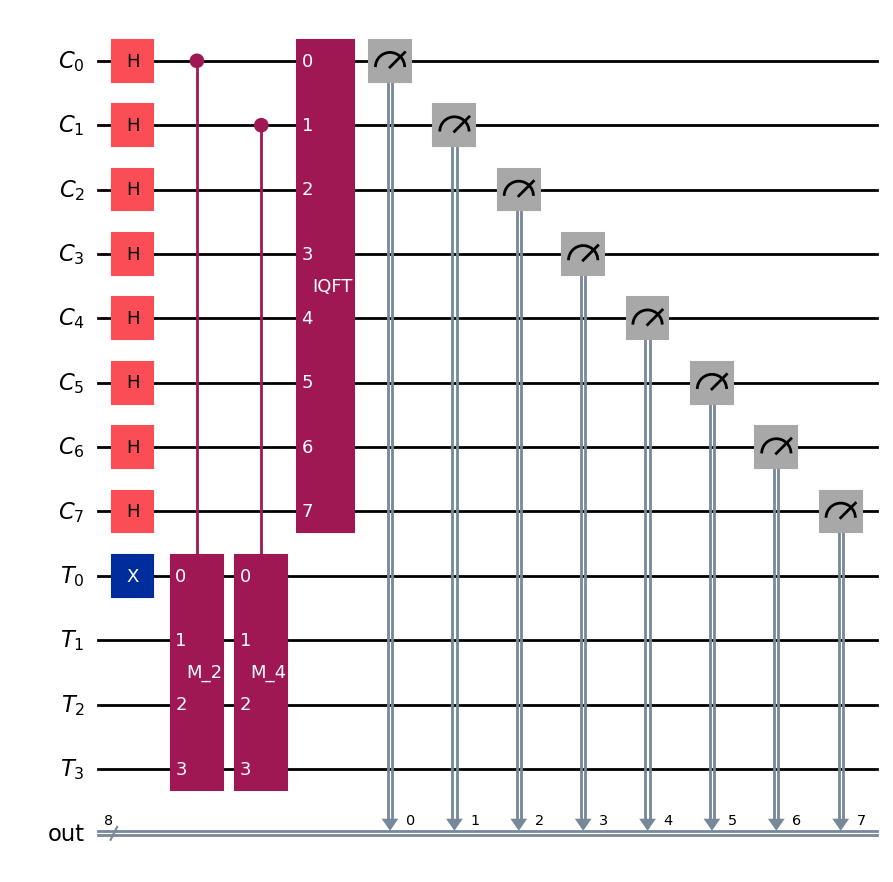

In [21]:
# Order finding problem for N = 15 with a = 2
N = 15
a = 2

# Number of qubits
num_target = floor(log(N - 1, 2)) + 1  # for modular exponentiation operators
num_control = 2 * num_target  # for enough precision of estimation

# List of M_b operators in order
k_list = range(num_control)
b_list = [a2kmodN(2, k, 15) for k in k_list]

# Initialize the circuit
control = QuantumRegister(num_control, name="C")
target = QuantumRegister(num_target, name="T")
output = ClassicalRegister(num_control, name="out")
circuit = QuantumCircuit(control, target, output)

# Initialize the target register to the state |1>
circuit.x(num_control)

# Add the Hadamard gates and controlled versions of the
# multiplication gates
for k, qubit in enumerate(control):
    circuit.h(k)
    b = b_list[k]
    if b == 2:
        circuit.compose(
            M2mod15().control(), qubits=[qubit] + list(target), inplace=True
        )
    elif b == 4:
        circuit.compose(
            M4mod15().control(), qubits=[qubit] + list(target), inplace=True
        )
    else:
        continue  # M1 is the identity operator

# Apply the inverse QFT to the control register
circuit.compose(QFT(num_control, inverse=True), qubits=control, inplace=True)

# Measure the control register
circuit.measure(control, output)

circuit.draw("mpl", fold=-1)

Observe que omitimos as operações de exponenciação modular controlada dos qubits de controle restantes porque $M_1$ é o operador de identidade.



Observe que, mais adiante neste tutorial, executaremos esse circuito no backend `ibm_marrakesh` . Para isso, transpilamos o circuito de acordo com esse backend específico e informamos a profundidade do circuito e a contagem de portas.



In [22]:
service = QiskitRuntimeService()
backend = service.backend("ibm_marrakesh")
pm = generate_preset_pass_manager(optimization_level=2, backend=backend)

transpiled_circuit = pm.run(circuit)

print(
    f"2q-depth: {transpiled_circuit.depth(lambda x: x.operation.num_qubits==2)}"
)
print(
    f"2q-size: {transpiled_circuit.size(lambda x: x.operation.num_qubits==2)}"
)
print(f"Operator counts: {transpiled_circuit.count_ops()}")
transpiled_circuit.draw(
    output="mpl", fold=-1, style="clifford", idle_wires=False
)

AccountNotFoundError: "Unable to find account. Please make sure an account with the channel name 'ibm_quantum_platform' is saved."

<span id="step-3-execute-using-qiskit-primitives" />

## Etapa 3: executar usando primitivas do Qiskit



Primeiro, discutimos o que teoricamente obteríamos se executássemos esse circuito em um simulador ideal. Abaixo, temos um conjunto de resultados de simulação do circuito acima usando 1024 fotos. Como podemos ver, obtemos uma distribuição aproximadamente uniforme em quatro cadeias de bits sobre os qubits de controle.



In [23]:
# Obtained from the simulator
counts = {"00000000": 264, "01000000": 268, "10000000": 249, "11000000": 243}

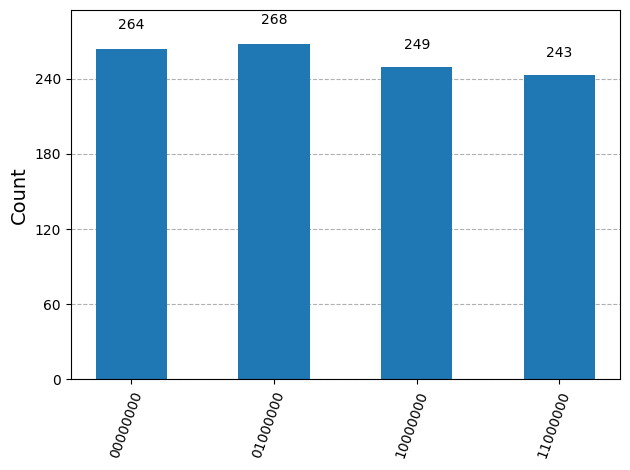

In [24]:
plot_histogram(counts)

Ao medir os qubits de controle, obtemos uma estimativa de fase de oito bits do operador $M_a$. Podemos converter essa representação binária em decimal para encontrar a fase medida. Como podemos ver no histograma acima, quatro cadeias de bits diferentes foram medidas, e cada uma delas corresponde a um valor de fase, como segue.



In [25]:
# Rows to be displayed in table
rows = []
# Corresponding phase of each bitstring
measured_phases = []

for output in counts:
    decimal = int(output, 2)  # Convert bitstring to decimal
    phase = decimal / (2**num_control)  # Find corresponding eigenvalue
    measured_phases.append(phase)
    # Add these values to the rows in our table:
    rows.append(
        [
            f"{output}(bin) = {decimal:>3}(dec)",
            f"{decimal}/{2 ** num_control} = {phase:.2f}",
        ]
    )

# Print the rows in a table
headers = ["Register Output", "Phase"]
df = pd.DataFrame(rows, columns=headers)
print(df)

            Register Output           Phase
0  00000000(bin) =   0(dec)    0/256 = 0.00
1  01000000(bin) =  64(dec)   64/256 = 0.25
2  10000000(bin) = 128(dec)  128/256 = 0.50
3  11000000(bin) = 192(dec)  192/256 = 0.75


Lembre-se de que qualquer fase medida corresponde a $\theta = k / r$, em que $k$ é amostrado uniformemente de forma aleatória a partir de $\{0, 1, \dots, r-1 \}$. Portanto, podemos usar o algoritmo de frações contínuas para tentar encontrar $k$ e a ordem $r$. Python tem essa funcionalidade incorporada. Podemos usar o módulo `fractions` para transformar um float em um objeto `Fraction` , por exemplo:



In [26]:
Fraction(0.666)

Fraction(5998794703657501, 9007199254740992)

Como isso fornece frações que retornam exatamente o resultado (nesse caso, `0.6660000...`), isso pode gerar resultados desagradáveis como o acima. Podemos usar o método `.limit_denominator()` para obter a fração que mais se assemelha ao nosso float, com um denominador abaixo de um determinado valor:



In [27]:
# Get fraction that most closely resembles 0.666
# with denominator < 15
Fraction(0.666).limit_denominator(15)

Fraction(2, 3)

Isso é muito mais agradável. A ordem (r) deve ser menor que N, portanto, definiremos o denominador máximo como sendo `15`:



In [28]:
# Rows to be displayed in a table
rows = []

for phase in measured_phases:
    frac = Fraction(phase).limit_denominator(15)
    rows.append(
        [phase, f"{frac.numerator}/{frac.denominator}", frac.denominator]
    )

# Print the rows in a table
headers = ["Phase", "Fraction", "Guess for r"]
df = pd.DataFrame(rows, columns=headers)
print(df)

   Phase Fraction  Guess for r
0   0.00      0/1            1
1   0.25      1/4            4
2   0.50      1/2            2
3   0.75      3/4            4


Podemos ver que dois dos valores próprios medidos nos forneceram o resultado correto: $r=4$, e podemos ver que o algoritmo de Shor para encontrar a ordem tem uma chance de falhar. Esses resultados ruins ocorrem porque $k = 0$, ou porque $k$ e $r$ não são coprimos - e, em vez de $r$, recebemos um fator de $r$. A solução mais fácil para isso é simplesmente repetir o experimento até obter um resultado satisfatório para $r$.



Até agora, implementamos o problema de localização de ordem para $N=15$ com $a=2$ usando o circuito de estimativa de fase em um simulador. A última etapa do algoritmo de Shor será relacionar o problema de determinação de ordem ao problema de fatoração de números inteiros. Essa última parte do algoritmo é puramente clássica e pode ser resolvida em um computador clássico após as medições de fase terem sido obtidas em um computador quântico. Portanto, adiamos a última parte do algoritmo para depois de demonstrarmos como podemos executar o circuito de localização de ordens em um hardware real.



<span id="hardware-runs" />

### O hardware é executado



Agora podemos executar o circuito de localização de ordens que transpilamos anteriormente para `ibm_marrakesh`. Aqui, recorremos ao [desacoplamento dinâmico](/docs/guides/error-mitigation-and-suppression-techniques#dynamical-decoupling) (DD) para supressão de erros e ao [giro de porta](/docs/guides/error-mitigation-and-suppression-techniques#pauli-twirling) para fins de atenuação de erros. O DD envolve a aplicação de sequências de pulsos de controle precisamente cronometrados a um dispositivo quântico, reduzindo efetivamente a média das interações ambientais indesejadas e da decoerência. O giro de porta, por outro lado, randomiza portas quânticas específicas para transformar erros coerentes em erros de Pauli, que se acumulam linearmente em vez de quadraticamente. Ambas as técnicas são frequentemente combinadas para aumentar a coerência e a fidelidade dos cálculos quânticos.



In [29]:
# Sampler primitive to obtain the probability distribution
sampler = Sampler(backend)

# Turn on dynamical decoupling with sequence XpXm
sampler.options.dynamical_decoupling.enable = True
sampler.options.dynamical_decoupling.sequence_type = "XpXm"
# Enable gate twirling
sampler.options.twirling.enable_gates = True

pub = transpiled_circuit
job = sampler.run([pub], shots=1024)

NameError: name 'backend' is not defined

In [30]:
result = job.result()[0]
counts = result.data["out"].get_counts()

NameError: name 'job' is not defined

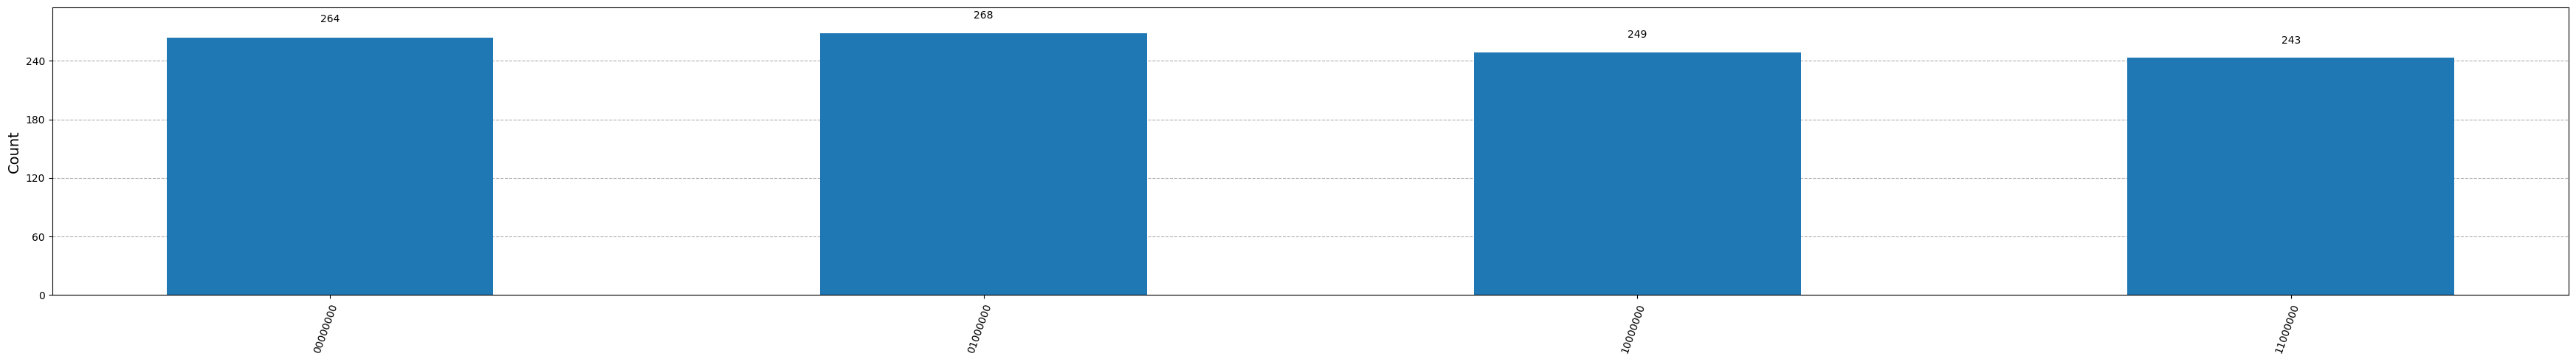

In [31]:
plot_histogram(counts, figsize=(35, 5))

Como podemos ver, obtivemos as mesmas cadeias de bits com contagens mais altas. Como o hardware quântico tem ruído, há algum vazamento para outras cadeias de bits, que podemos filtrar estatisticamente.



In [32]:
# Dictionary of bitstrings and their counts to keep
counts_keep = {}
# Threshold to filter
threshold = np.max(list(counts.values())) / 2

for key, value in counts.items():
    if value > threshold:
        counts_keep[key] = value

print(counts_keep)

{'00000000': 264, '01000000': 268, '10000000': 249, '11000000': 243}


<span id="step-4-post-process-and-return-result-in-desired-classical-format" />

## Etapa 4: Pós-processamento e retorno do resultado no formato clássico desejado



<span id="integer-factorization" />

### Fatoração de números inteiros



Até agora, discutimos como podemos implementar o problema de determinação de ordem usando um circuito de estimativa de fase. Agora, conectamos o problema de determinação de ordem à fatoração de números inteiros, o que completa o algoritmo de Shor. Observe que essa parte do algoritmo é clássica.



Agora demonstramos isso usando nosso exemplo de $N = 15$ e $a = 2$. Lembre-se de que a fase que medimos é $k / r$, em que $a^r \; (\textrm{mod} \; N) = 1$ e $k$ é um número inteiro aleatório entre $0$ e $r - 1$. A partir dessa equação, temos $(a^r - 1) \; (\textrm{mod} \; N) = 0,$, o que significa que $N$ deve dividir $a^r-1$. Se $r$ também for par, podemos escrever $a^r -1 = (a^{r/2}-1)(a^{r/2}+1).$. Se $r$ não for par, não podemos ir adiante e devemos tentar novamente com um valor diferente para $a$; caso contrário, há uma grande probabilidade de que o maior divisor comum de $N$ e $a^{r/2}-1$ ou $a^{r/2}+1$ seja um fator próprio de $N$.

Como algumas execuções do algoritmo falharão estatisticamente, repetiremos esse algoritmo até que pelo menos um fator de $N$ seja encontrado.



A célula abaixo repete o algoritmo até que pelo menos um fator de $N=15$ seja encontrado. Usaremos os resultados da execução de hardware acima para adivinhar a fase e o fator correspondente em cada iteração.



In [33]:
a = 2
N = 15

FACTOR_FOUND = False
num_attempt = 0

while not FACTOR_FOUND:
    print(f"\nATTEMPT {num_attempt}:")
    # Here, we get the bitstring by iterating over outcomes
    # of a previous hardware run with multiple shots.
    # Instead, we can also perform a single-shot measurement
    # here in the loop.
    bitstring = list(counts_keep.keys())[num_attempt]
    num_attempt += 1
    # Find the phase from measurement
    decimal = int(bitstring, 2)
    phase = decimal / (2**num_control)  # phase = k / r
    print(f"Phase: theta = {phase}")

    # Guess the order from phase
    frac = Fraction(phase).limit_denominator(N)
    r = frac.denominator  # order = r
    print(f"Order of {a} modulo {N} estimated as: r = {r}")

    if phase != 0:
        # Guesses for factors are gcd(a^{r / 2} ± 1, 15)
        if r % 2 == 0:
            x = pow(a, r // 2, N) - 1
            d = gcd(x, N)
            if d > 1:
                FACTOR_FOUND = True
                print(f"*** Non-trivial factor found: {x} ***")


ATTEMPT 0:
Phase: theta = 0.0
Order of 2 modulo 15 estimated as: r = 1

ATTEMPT 1:
Phase: theta = 0.25
Order of 2 modulo 15 estimated as: r = 4
*** Non-trivial factor found: 3 ***


<span id="discussion" />

## Discussão



<span id="related-work" />

### Trabalho relacionado

Nesta seção, discutiremos outros trabalhos importantes que demonstraram o algoritmo de Shor em hardware real.

O trabalho seminal [\[3\]](#references) de IBM® demonstrou o algoritmo de Shor pela primeira vez, fatorando o número 15 em seus fatores primos 3 e 5 usando um computador quântico de ressonância magnética nuclear (NMR) de sete qubits. Outro experimento [\[4\]](#references) fatorou 15 usando qubits fotônicos. Empregando um único qubit reciclado várias vezes e codificando o registro de trabalho em estados de dimensões mais altas, os pesquisadores reduziram o número necessário de qubits para um terço do protocolo padrão, utilizando um algoritmo compilado de dois fótons. Um artigo importante na demonstração do algoritmo de Shor é [\[5\]](#references), que usa a técnica de estimativa de fase iterativa de Kitaev [\[8\]](#references) para reduzir o requisito de qubit do algoritmo. Os autores usaram sete qubits de controle e quatro qubits de cache, juntamente com a implementação de multiplicadores modulares. Essa implementação, no entanto, exige medições no meio do circuito com operações de avanço e reciclagem de qubit com operações de reinicialização. Essa demonstração foi feita em um computador quântico de armadilha de íons.

Um trabalho mais recente [\[6\]](#references) concentrou-se na fatoração de 15, 21 e 35 no hardware IBM Quantum®. Semelhante ao trabalho anterior, os pesquisadores usaram uma versão compilada do algoritmo que empregou uma transformada quântica de Fourier semiclássica, conforme proposto por Kitaev, para minimizar o número de qubits e portas físicas. Um trabalho mais recente [\[7\]](#references) também realizou uma demonstração de prova de conceito para fatorar o inteiro 21. Essa demonstração também envolveu o uso de uma versão compilada da rotina de estimativa de fase quântica e se baseou na demonstração anterior de [\[4\]](#references). Os autores foram além desse trabalho, usando uma configuração de portas Toffoli aproximadas com mudanças de fase residuais. O algoritmo foi implementado em processadores quânticos IBM usando apenas cinco qubits, e a presença de emaranhamento entre o controle e os qubits de registro foi verificada com sucesso.



<span id="scaling-of-the-algorithm" />

### Dimensionamento do algoritmo

Observamos que a criptografia RSA normalmente envolve tamanhos de chave da ordem de 2048 a 4096 bits. A tentativa de fatorar um número de 2048 bits com o algoritmo de Shor resultará em um circuito quântico com milhões de qubits, incluindo a sobrecarga de correção de erros e uma profundidade de circuito da ordem de um bilhão, o que está além dos limites de execução do hardware quântico atual. Portanto, o algoritmo de Shor exigirá métodos otimizados de construção de circuitos ou correção robusta de erros quânticos para ser praticamente viável na quebra de sistemas criptográficos modernos. Consulte [\[9\]](#references) para obter uma discussão mais detalhada sobre a estimativa de recursos para o algoritmo de Shor.



<span id="challenge" />

## Desafio

Parabéns por ter concluído o tutorial! Agora é um ótimo momento para testar sua compreensão. Você poderia tentar construir o circuito para fatorar 21? Você pode selecionar um $a$ de sua preferência. Você precisará decidir sobre a precisão de bits do algoritmo para escolher o número de qubits, e precisará projetar os operadores de exponenciação modular $M_a$. Recomendamos que você experimente fazer isso por conta própria e depois leia sobre as metodologias mostradas na Fig. 9 de [\[6\]](#references) e na Fig. 2 de [\[7\]](#references).



#### ETAPAS PAS PARA FAZER A FATORAÇÃO DE 21

- Escolher um a que seja coprimo de 21
- Calcular as potências necessárias
- Fazer as tabelas de permutação para entender oq M_a faz
- Fazer uma matriz de permutação e fazer com que o Qiskit decomponha
- Fazer o QPE
- Encontrar r e fatorar 21

In [ ]:
def M_a_mod21():
    """
    M_a (mod 21)
    """

    # Your code here
    pass

<span id="references" />

## Referências

1.  Shor, Peter W. " [Algoritmos de tempo polinomial para fatoração de primos e logaritmos discretos em um computador quântico](https://epubs.siam.org/doi/abs/10.1137/S0036144598347011)." SIAM review 41.2 (1999): 303-332.
2.  IBM Curso Quantum [Fundamentals of Quantum Algorithms](https://learning.quantum.ibm.com/course/fundamentals-of-quantum-algorithms/phase-estimation-and-factoring), ministrado pelo Dr. John Watrous.
3.  Vandersypen, Lieven MK, et al. " [Realização experimental do algoritmo de fatoração quântica de Shor usando ressonância magnética nuclear](https://www.nature.com/articles/414883a)." Nature 414.6866 (2001): 883-887.
4.  Martin-Lopez, Enrique, et al. "[Realização experimental do algoritmo de fatoração quântica de Shor usando reciclagem de qubit](https://www.nature.com/articles/nphoton.2012.259) " Nature photonics 6.11 (2012): 773-776.
5.  Monz, Thomas, et al. "[Realização de um algoritmo Shor escalável](https://www.science.org/doi/full/10.1126/science.aad9480) " Science 351.6277 (2016): 1068-1070.
6.  Amico, Mirko, Zain H. Saleem e Muir Kumph. "[Estudo experimental do algoritmo de fatoração de Shor usando o IBM Q Experience](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.100.012305)." Physical Review A 100.1 (2019): 012305.
7.  Skosana, Unathi e Mark Tame. "[Demonstração do algoritmo de fatoração de Shor para N=21 em processadores quânticos IBM](https://www.nature.com/articles/s41598-021-95973-w)." Relatórios científicos 11.1 (2021): 16599.
8.  Kitaev, A. Yu. "[Medições quânticas e o problema do estabilizador abeliano](https://arxiv.org/abs/quant-ph/9511026) " arXiv preprint quant-ph/9511026 (1995).
9.  Gidney, Craig e Martin Ekerå. "[Como fatorar números inteiros RSA de 2048 bits em 8 horas usando 20 milhões de qubits ruidosos](https://doi.org/10.22331/q-2021-04-15-433)." Quantum 5 (2021): 433.



© IBM Corp., 2017-2025